In [1]:
import numpy as np
import numpy.random as rnd
import os.path
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KernelDensity



# Where to save the figures
PROJECT_ROOT_DIR = "."
Datafolder = "data"

######### Function To Save Figures to Directory #########
def save_fig(fig_id, tight_layout=True):
    image_dir = os.path.join(PROJECT_ROOT_DIR, "images")
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
    path = os.path.join(image_dir, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
#########Function for Loading Crime Data ############


def load_crime_data(file_name=Datafolder):
    csv_path = os.path.join("Data",file_name)
    print(csv_path)
    return pd.read_csv(csv_path)


######### Data Cleanup and Extract Data For Year #########

def get_clean_year(data,year):
    YearData=data[data['FIRST_OCCURRENCE_DATE'].str.contains(str(year))==True]
    YearData=YearData[YearData["Y"]>2]
    #Extract Just Criminal Acts
    criminal_acts=YearData[YearData["IS_CRIME"]>0]
    criminal_acts['cnt']=1
    grouped=criminal_acts.groupby(['X','Y'],as_index=False)
    a=grouped.aggregate(np.sum)
    #Code to Remove One off incidents. 
    final_data=a[["X","Y","cnt"]]
    final_data=final_data[final_data["cnt"]>1]
    return final_data


######### Data Cleanup and Extract Data For Year #########

def plotonmap(data,year):
    denv_img=plt.imread(os.path.join(PROJECT_ROOT_DIR,'prepared_images','denver.jpg'))
    ax = data.plot(kind="scatter", x="X", y="Y", figsize=(15,7),
                       label="Crime Spots "+str(year),
                       c="cnt", cmap=plt.get_cmap("jet"),
                       colorbar=True, alpha=0.1,
                      )
    plt.legend(fontsize=16)
    plt.imshow(denv_img,extent=[-105.109927,-104.600296,39.614431,39.914247],alpha=0.5)
    plt.tight_layout()
    plt.ylabel("Latitude", fontsize=14)
    plt.xlabel("Longitude", fontsize=14)
    filename='CrimePlot'
    extension='.jpg'
    filename+=str(year)+extension
    plt.savefig(filename)
    plt.show()
    
    
######### Bining and Kernel Density Analysis #########


def griddata(x, y, z, binsize=0.005, retbin=True, retloc=True):
    """
    Place unevenly spaced 2D data on a grid by 2D binning (nearest
    neighbor interpolation).
    
    Parameters
    ----------
    x : ndarray (1D)
        The idependent data x-axis of the grid.
    y : ndarray (1D)
        The idependent data y-axis of the grid.
    z : ndarray (1D)
        The dependent data in the form z = f(x,y).
    binsize : scalar, optional
        The full width and height of each bin on the grid.  If each
        bin is a cube, then this is the x and y dimension.  This is
        the step in both directions, x and y. Defaults to 0.01.
    retbin : boolean, optional
        Function returns `bins` variable (see below for description)
        if set to True.  Defaults to True.
    retloc : boolean, optional
        Function returns `wherebins` variable (see below for description)
        if set to True.  Defaults to True.
   
    Returns
    -------
    grid : ndarray (2D)
        The evenly gridded data.  The value of each cell is the median
        value of the contents of the bin.
    bins : ndarray (2D)
        A grid the same shape as `grid`, except the value of each cell
        is the number of points in that bin.  Returns only if
        `retbin` is set to True.
    wherebin : list (2D)
        A 2D list the same shape as `grid` and `bins` where each cell
        contains the indicies of `z` which contain the values stored
        in the particular bin.
    """
    
    # get extreme values.
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    # make coordinate arrays.
    xi      = np.arange(xmin, xmax+binsize, binsize)
    yi      = np.arange(ymin, ymax+binsize, binsize)
    xi, yi = np.meshgrid(xi,yi)

    # make the grid.
    grid = np.zeros(xi.shape, dtype=x.dtype)
    nrow, ncol = grid.shape
    if retbin: bins = np.copy(grid)

    # create list in same shape as grid to store indices
    if retloc:
        wherebin = np.copy(grid)
        wherebin = wherebin.tolist()
    
     
    # fill in the grid.
    for row in range(nrow):
        for col in range(ncol):
            xc = xi[row, col]    # x coordinate.
            yc = yi[row, col]    # y coordinate.

            # find the position that xc and yc correspond to.
            posx = np.abs(x - xc)
            posy = np.abs(y - yc)
            ibin = np.logical_and(posx < binsize/2., posy < binsize/2.)
            ind  = np.where(ibin == True)[0]
            
            # fill the bin.
            bin1 = z[ibin]
            if retloc: wherebin[row][col] = ind
            if retbin: bins[row, col] = bin1.size
            if bin1.size != 0:
                #Generate The Kernel Density Probabilty of Each Kernel
                
                bin1=[i for i in bin1]
                bin1=np.array(bin1)[:, np.newaxis]
                kde = KernelDensity(bandwidth=0.04, metric='haversine',
                        kernel='gaussian', algorithm='ball_tree')
                kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(bin1)
                bins_hist=np.linspace(np.amin(bin1),np.amax(bin1))
                bins_hist=[a for a in bins_hist]
                bins_hist=np.array(bins_hist)[:, np.newaxis]
                log_dens = kde.score_samples(bins_hist)
                binval         = np.mean(log_dens)
                grid[row, col] = binval
            else:
                grid[row, col] = np.nan   # fill empty bins with nans.

    # return the grid
    if retbin:
        if retloc:
            return grid, bins, wherebin
        else:
            return grid, bins
    else:
        if retloc:
            return grid, wherebin
        else:
            return grid    

        
        
##### Calling the KDE Function and Plotting Data
def KDE_data(final_data,year):
    
    x,y,z=final_data["X"],final_data["Y"],final_data["cnt"]
    my_grid=griddata(x.values,y.values,z.values)
    grid, bins, binloc=my_grid
    zmin=grid[np.where(np.isnan(grid) == False)].min()
    zmax=grid[np.where(np.isnan(grid) == False)].max()
    extent = (x.min(), x.max(), y.min(), y.max()) # extent of the plot
    # now show the number of points in each bin.  since the independent data are
    # Gaussian distributed, we expect a 2D Gaussian.
    plt.figure(figsize=(15,7))
    plt.imshow(bins, extent=extent, cmap=plt.get_cmap("jet"), origin='lower', vmin=0, vmax=bins.max(), aspect='auto', interpolation='bilinear')
    plt.xlabel('Logitutude')
    plt.ylabel('Lattitude')
    title='Kernel Density Heat Map In Denver - Crime Data '
    title+=str(year)
    filename='KDE_Plot'
    extension='.jpg'
    filename+=str(year)+extension
    plt.title(title)
    plt.colorbar()
    plt.show()
    plt.savefig(filename)

In [2]:
crime_data=load_crime_data("crime.csv")

Data\crime.csv


In [3]:
Data2011=get_clean_year(crime_data,2011)
Data2012=get_clean_year(crime_data,2012)
Data2013=get_clean_year(crime_data,2013)
Data2014=get_clean_year(crime_data,2014)
Data2015=get_clean_year(crime_data,2015)
Data2016=get_clean_year(crime_data,2016)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


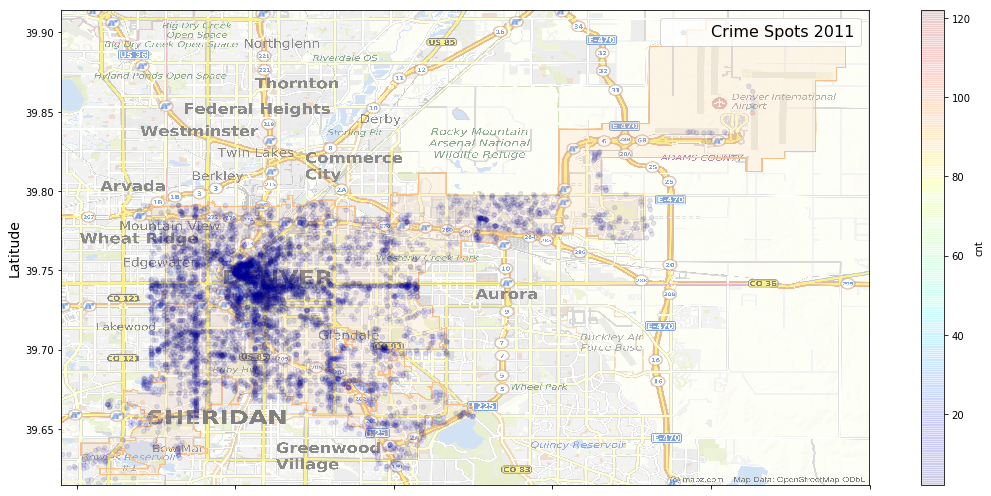

In [4]:
## Crime Analysis of 2011 Data
plotonmap(Data2011,2011)

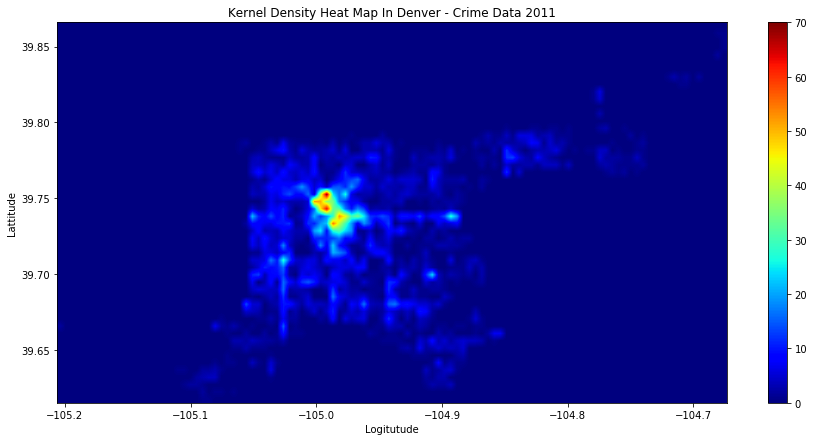

In [6]:
## Crime Kernel Density Analysis for 2011
KDE_data(Data2011,2011)

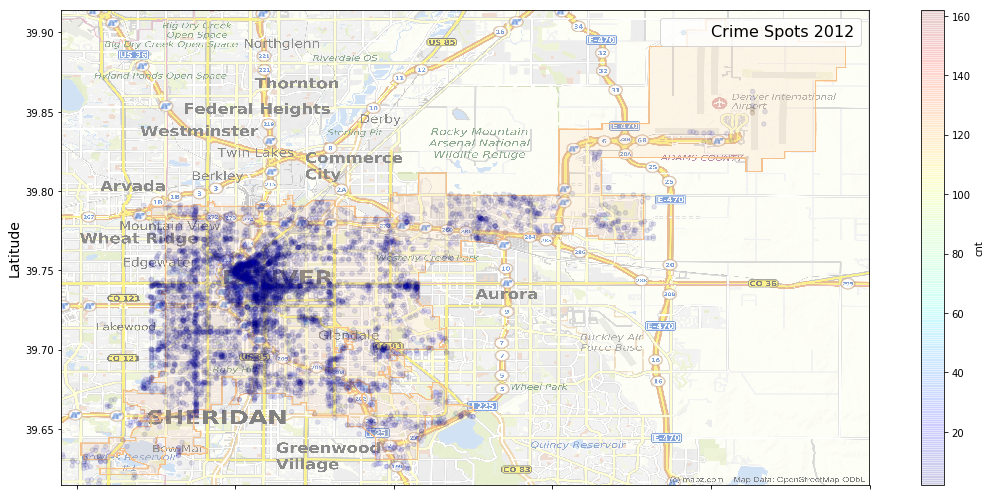

In [7]:
## Crime Analysis of 2012 Data
plotonmap(Data2012,2012)

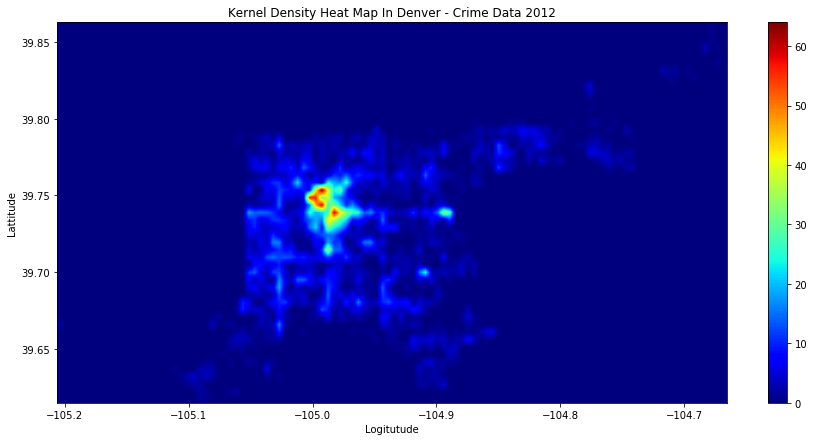

In [8]:
## Crime Analysis of 2012 Data

KDE_data(Data2012,2012)

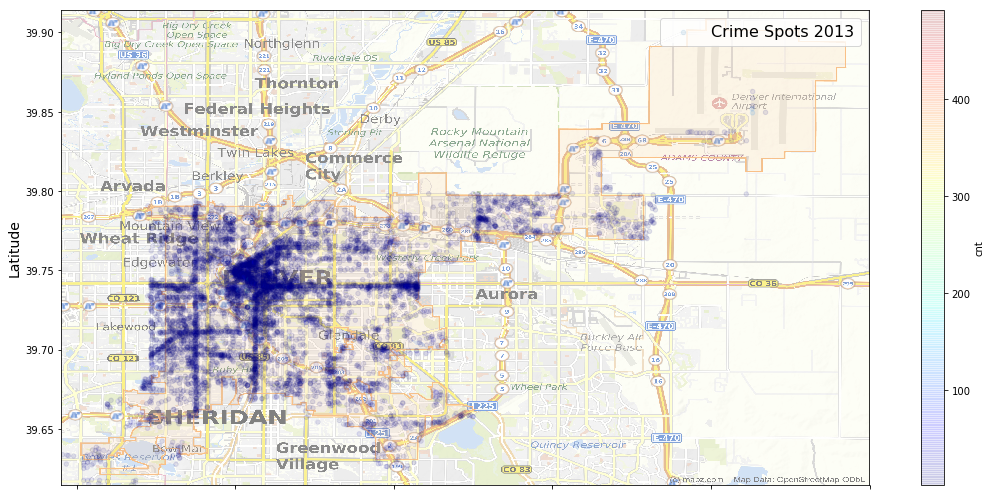

In [9]:
## Crime Analysis of 2013 Data
plotonmap(Data2013,2013)

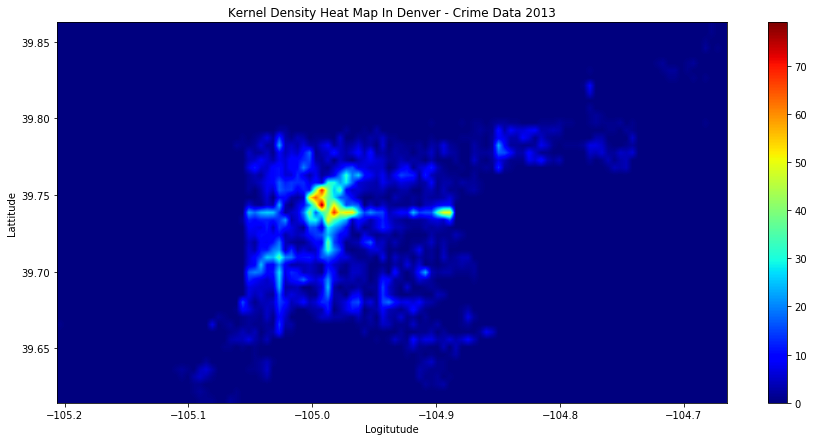

In [10]:
## Crime Analysis of 2013 Data

KDE_data(Data2013,2013)

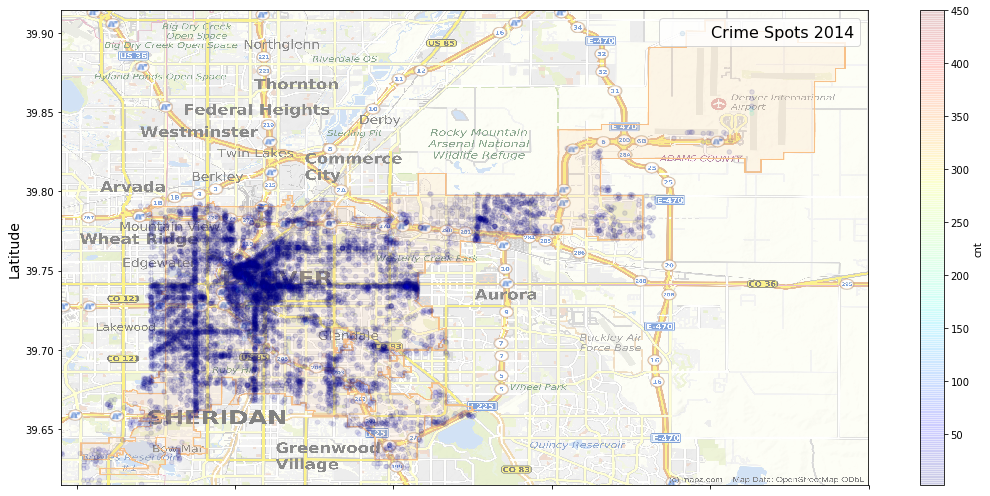

In [11]:
## Crime Analysis of 2014 Data
plotonmap(Data2014,2014)

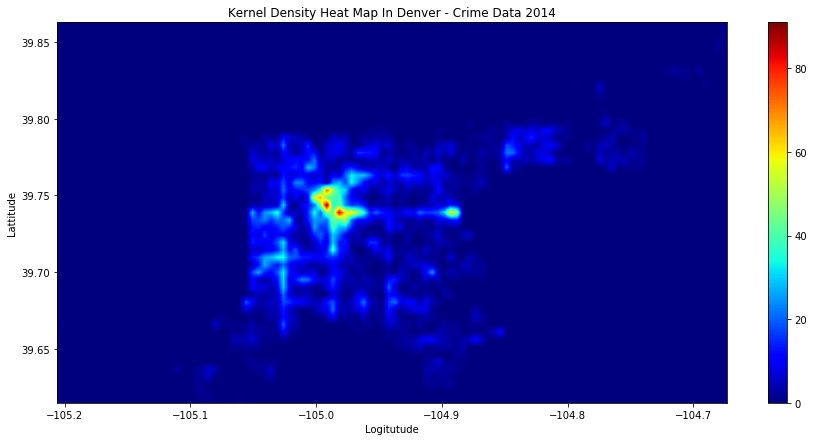

In [12]:
## Crime Analysis of 2014 Data

KDE_data(Data2014,2014)

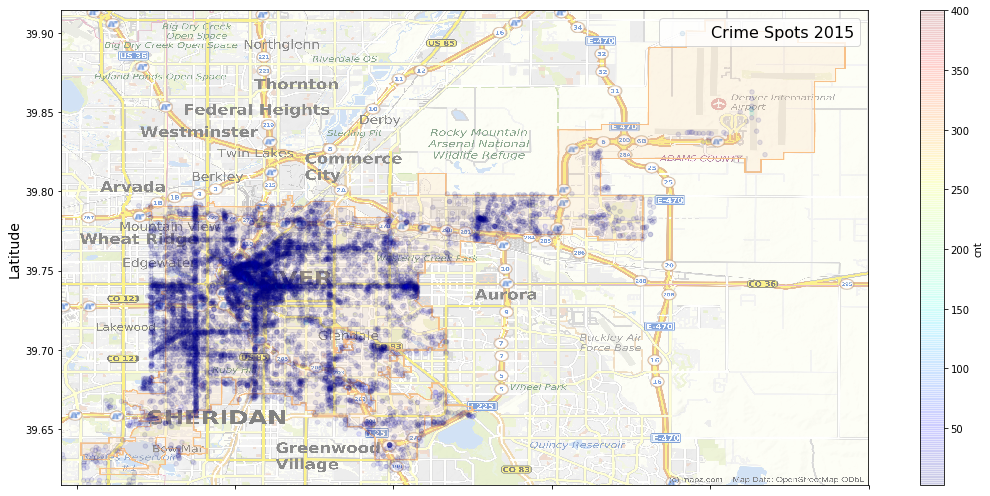

In [13]:
## Crime Analysis of 2015 Data
plotonmap(Data2015,2015)

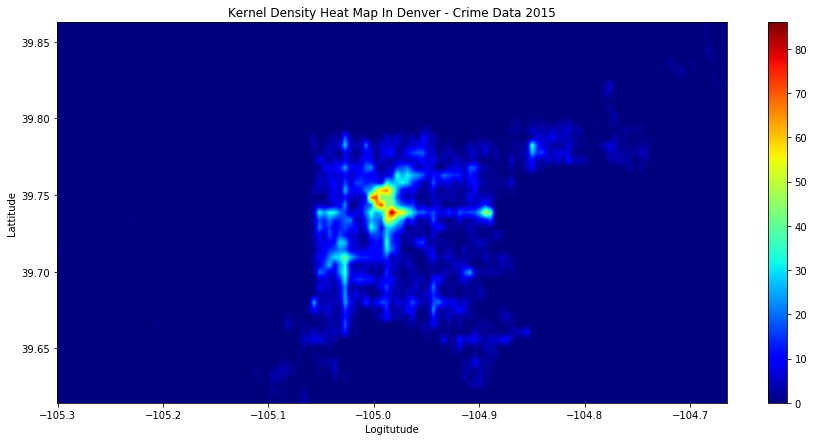

In [15]:
## Crime Analysis of 2015 Data

KDE_data(Data2015,2015)

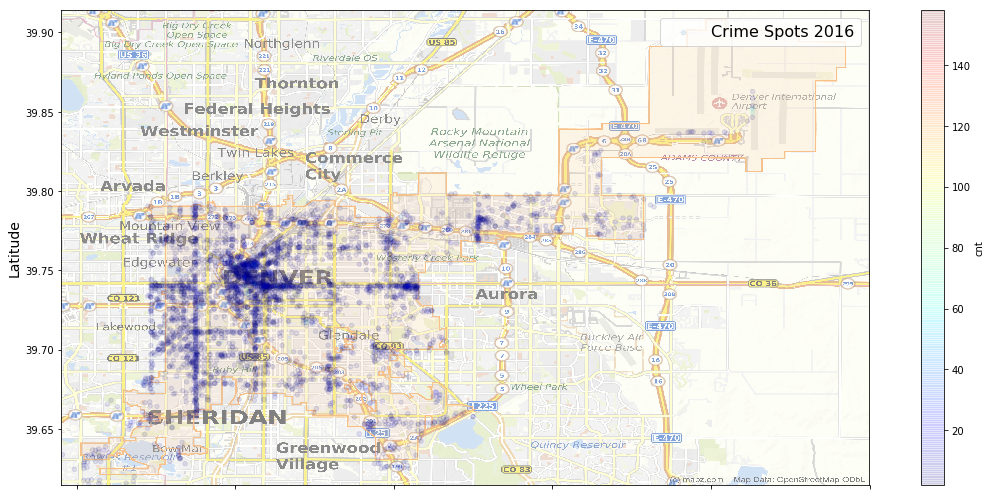

In [14]:
## Crime Analysis of 2016 Data
plotonmap(Data2016,2016)

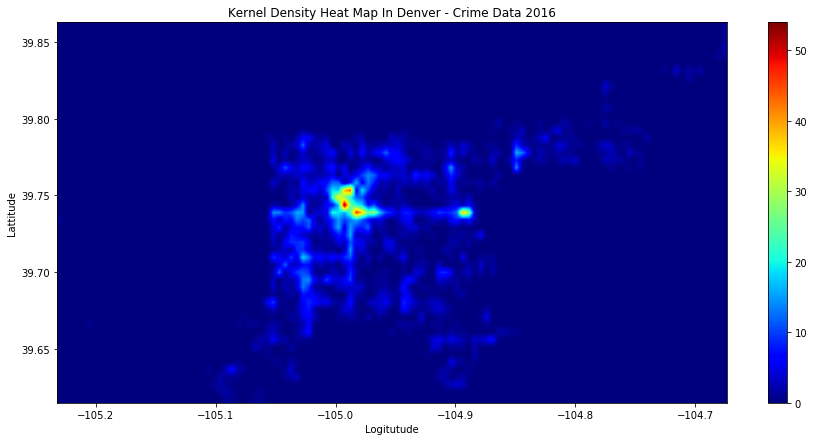

In [15]:
## Crime Analysis of 2016 Data

KDE_data(Data2016,2016)